In [1]:
!pip install -q datasets trl transformers scikit-learn rapidfuzz nltk wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec

# 1. Data Ingestion

In [39]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

train_df = pd.read_excel('/content/nlp_data.xlsx', 'Train')
train_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [40]:
test_df = pd.read_excel('/content/nlp_data.xlsx', 'Test')
test_df.head()

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Hobo With a Shotgun�۪ iPhone app #SXSW {link}
1,Again? RT @mention Line at the Apple store is insane.. #sxsw
2,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw"
3,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
4,���@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow


# 2. Data Analysis

In [41]:
# check for null values
train_df.isna().sum()

,0
tweet_text,1
emotion_in_tweet_is_directed_at,5298
is_there_an_emotion_directed_at_a_brand_or_product,0


In [42]:
# removing the null tweet rows
train_df = train_df.dropna(subset=['tweet_text'])

In [43]:
# checking the number of classes and their count
train_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5388
Positive emotion,2672
Negative emotion,519
I can't tell,9


In [44]:
# checking the proportion of classes and their count
train_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)*100

,proportion
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,62.738705
Positive emotion,31.113181
Negative emotion,6.043316
I can't tell,0.104797


In [45]:
# checking the number of unique values and their count
train_df['emotion_in_tweet_is_directed_at'].value_counts()

,count
emotion_in_tweet_is_directed_at,
iPad,946
Apple,661
iPad or iPhone App,470
Google,430
iPhone,297
Other Google product or service,293
Android App,81
Android,78
Other Apple product or service,35


In [46]:
# Checking the Value Counts for Sentiment when the emotion_in_tweet_is_directed_at is null
train_df[train_df['emotion_in_tweet_is_directed_at'].isna()].is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5297


In [47]:
# observing values
train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Negative emotion" ].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion
38,@mention - False Alarm: Google Circles Not Coming Now���and Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative emotion
65,attending @mention iPad design headaches #sxsw {link},iPad,Negative emotion


In [48]:
# observing values
train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "Positive emotion" ].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion


In [49]:
# observing values
train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product" ].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product


In [50]:
# observing values
train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell" ].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
2475,I won't be at #sxsw and I won't be in line to buy iPad 2.0 tomorrow. #notwinning.,iPad,I can't tell
3275,I am neither at #SXSW nor buying an iPad 2 today. I feel like my geek cred is basically gone.,iPad,I can't tell
3776,"I feel like my iPhone: Always on, always doing something, running out of battery fast. #sxsw",iPhone,I can't tell
5349,RT @mention Design for iPad is like design 101. Will someone give a talk and assume that we didn't all ditch our prev experience #sxsw,iPad,I can't tell
6819,Google should put those engineers formerly behind real estate listings into renewing the Google Checkout project. #SXSW,Other Google product or service,I can't tell


In [51]:
# importing necessary libraries for plotting

import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [52]:
# shortening the label names
train_df['is_there_an_emotion_directed_at_a_brand_or_product'] = train_df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({"No emotion toward brand or product":"No emotion"})

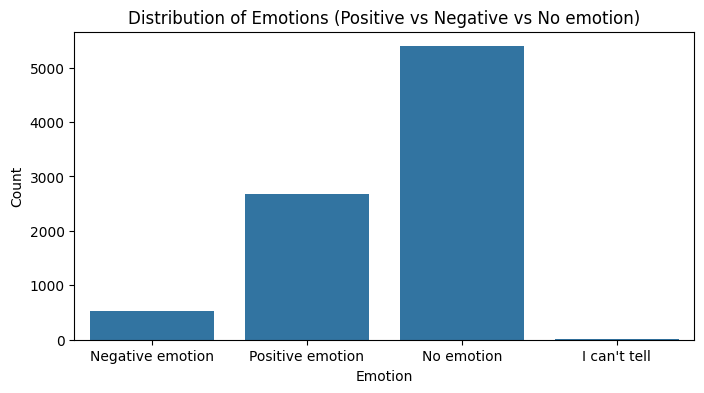

In [53]:
# sentiment distribution analysis
plt.figure(figsize=(8, 4))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=train_df)
plt.title("Distribution of Emotions (Positive vs Negative vs No emotion)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

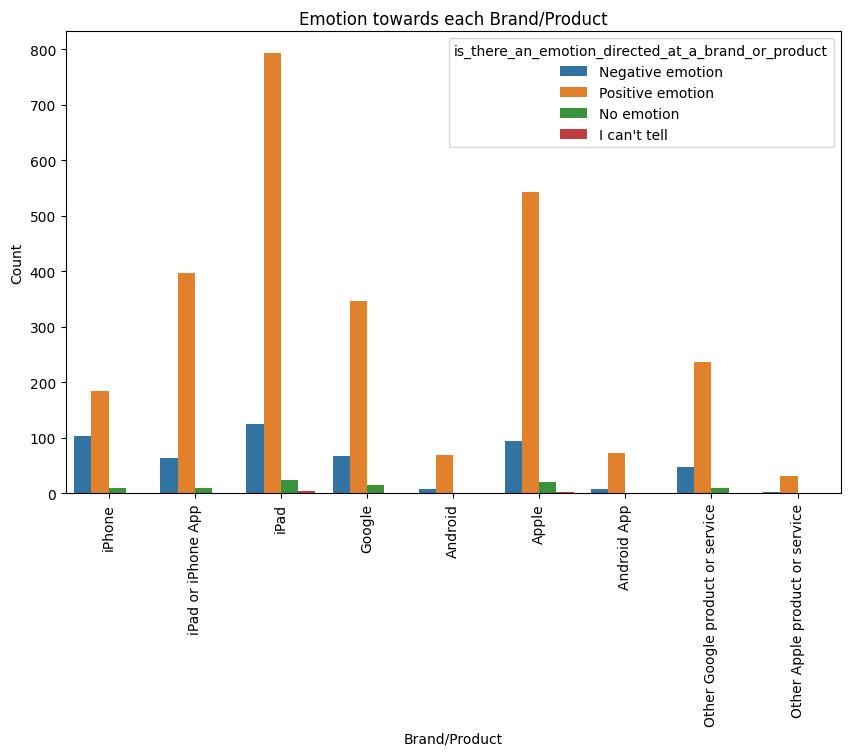

In [54]:
# emotion for each brand / product
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_directed_at_a_brand_or_product', data=train_df)
plt.title("Emotion towards each Brand/Product")
plt.xlabel("Brand/Product")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

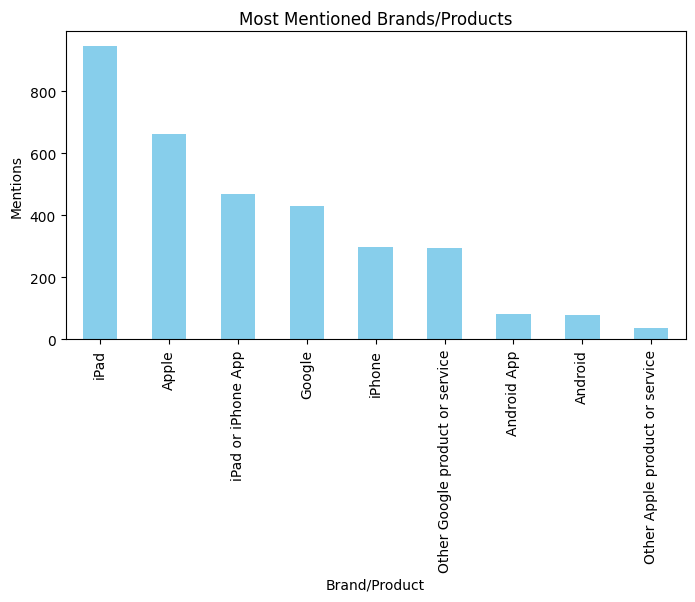

In [55]:
# most mentioned brands in the dataset
brand_counts = train_df['emotion_in_tweet_is_directed_at'].value_counts()
plt.figure(figsize=(8, 4))
brand_counts.plot(kind='bar', color='skyblue')
plt.title("Most Mentioned Brands/Products")
plt.xlabel("Brand/Product")
plt.ylabel("Mentions")
plt.show()

In [56]:
# changing the label name back to normal
train_df['is_there_an_emotion_directed_at_a_brand_or_product'] = train_df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({"No emotion":"No emotion toward brand or product"})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


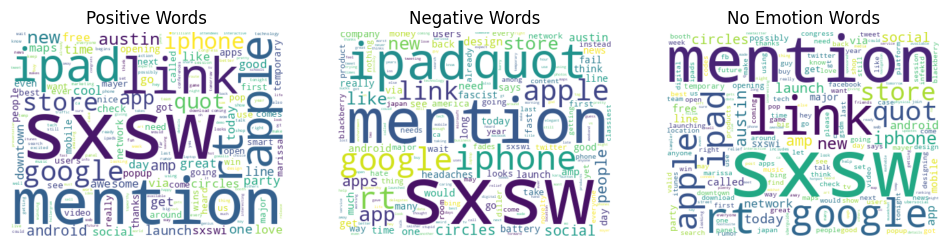

In [57]:
# -------- creaing word cloud ------------------

# importing necessary libraries
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# function to preprocess text (tokenization + stopword removal)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]


# separate positive, negative and no emotion tweets
positive_tweets = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['tweet_text']
negative_tweets = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['tweet_text']
no_emotion_tweets = train_df[train_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']['tweet_text']

# preprocess the tweets to get word frequencies
positive_words = Counter([word for tweet in positive_tweets for word in preprocess_text(tweet)])
negative_words = Counter([word for tweet in negative_tweets for word in preprocess_text(tweet)])
no_emotion_words = Counter([word for tweet in no_emotion_tweets for word in preprocess_text(tweet)])


# plotting the word cloud
plt.figure(figsize=(12, 6))

# positive sentiment word cloud
plt.subplot(1, 3, 1)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(positive_words)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Words")
plt.axis('off')

# negative sentiment word cloud
plt.subplot(1, 3, 2)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(negative_words)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Words")
plt.axis('off')

# no sentiment word cloud
plt.subplot(1, 3, 3)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(no_emotion_words)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("No Emotion Words")
plt.axis('off')

plt.show()

### Findings

- Every row in the `tweet_text` has the hashtag `#sxsw`
- The dataset is imbalanced, with `No emotion` taking more than 60% of the data, while the `Negative emotion` accounting only 6%
- The `I can't tell` label has the least proportion, that is, it contains only 0.1% of the whole dataset, hence can be ignored
- Almost all the tweets are either about Iphone, Ipad, Google and something related to these devices / services


### Data Quality

- `emotion_in_tweet_is_directed_at` is `NaNs` for all rows that are not having either `Positive emotion` or `Negative emotion` in their last column
- The dataset has non english characters, which can be observed in the first few rows on the `test_data`, and they are present in `training_data` too
- Upon a closer inspection in the Excel, dataset contains URLs, HTML reference characters as well
- Some of the URLs have been replaced with `{link}`
- The data contains too many near duplicates(not exact duplicates). And there are cases where, when tweet is same, the emotion is different
- The labels are not consistent, that is, there are some wrong labels present in the dataset


# 3. Data Pre-Processing

Data pre-processing will undergo the following

0. Change the data to lowercase
1. Remove the rows with `I can't tell` as it as low proportion in the dataset
2. removing all the @mention as they do not provide any value
3. Remove HTML Elements, URLs
4. Remove Non English Characters
5. Remove exact duplicates
6. Remove near exact duplicates

In [58]:
# creating a copy of the train_df
train_df_clean = train_df.copy()

In [59]:
# removing "I can't tell" rows as they have very low proportion of values
train_df_clean = train_df_clean[train_df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
train_df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product'], dtype=object)

In [60]:
# converting to lower case
train_df_clean.tweet_text = train_df_clean.tweet_text.str.lower()
train_df_clean.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative emotion
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive emotion


In [61]:
import re
import html

# function to clean / process the text data
def clean_text(text):
    # unescaping HTML entities (e.g., &lt; becomes <, &amp; becomes amp)
    text = html.unescape(text)

    # remove {links} from text
    text = text.replace("{link}",'')

    # regular expression to match URLs
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text) # Removes http, https, www

    # replace all the @names with @mention along with any leading and ending dot(.) if present
    text = re.sub(r'\.?@\w+\.?', '', text)

    # remove all the non english characters
    text = re.sub(r'[^A-Za-z0-9\s.,!?\'";:()&\-\#]', '', text)

    # remove any leading / trailing spaces if created
    text = text.strip()

    return text

In [62]:
# taking an example row
text = html.unescape("���.@mention. {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW")
print(text)

text = text.replace("{link}",'')
print(text)

text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
print(text)

text = re.sub(r'\.?@\w+\.?', '', text)
print(text)

text = re.sub(r'[^A-Za-z0-9\s.,!?\'";:()&\-\#]', '', text)
print(text)

���.@mention. {link} <-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW
���.@mention.  <-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW
���.@mention.  <-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW
���  <-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW
  -- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW


In [63]:
# apply the function to the 'text' column
train_df_clean['tweet_text'] = train_df_clean['tweet_text'].apply(clean_text)
train_df_clean.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,"i have a 3g iphone. after 3 hrs tweeting at #riseaustin, it was dead! i need to upgrade. plugin stations at #sxsw.",iPhone,Negative emotion
1,"know about ? awesome ipadiphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",iPad or iPhone App,Positive emotion
2,can not wait for #ipad 2 also. they should sale them down at #sxsw.,iPad,Positive emotion
3,i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,iPad or iPhone App,Negative emotion
4,"great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech booksconferences) & matt mullenweg (wordpress)",Google,Positive emotion


In [64]:
# removing the emotion_in_tweet_is_directed_at as we do not need it
train_df_clean.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [65]:
train_df_clean.rename(columns={
    'tweet_text': 'text',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'label'
}, inplace=True)

train_df_clean.head()

,text,label
0,"i have a 3g iphone. after 3 hrs tweeting at #riseaustin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion
1,"know about ? awesome ipadiphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion
2,can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion
3,i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion
4,"great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech booksconferences) & matt mullenweg (wordpress)",Positive emotion


In [66]:
# checking for exact duplicates
duplicates = train_df_clean['text'].duplicated()

# count the number of duplicate rows
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 156


In [67]:
# view the  duplicates
train_df_clean[duplicates]

,text,label
239,my iphone and i are both very thirsty! #sxsw ( chevy volt lounge w 16 others),No emotion toward brand or product
273,"at #sxsw, apple schools the marketing experts",Positive emotion
364,"hootsuite blog social media dashboard hootsuite mobile for #sxsw updates for iphone, blackberry & android",No emotion toward brand or product
449,"before it even begins, apple wins #sxsw",Positive emotion
450,"before it even begins, apple wins #sxsw",Positive emotion
...,...,...
8140,are you stupid? find it out at the #sxsw on your mac for a special price! #games #mac,No emotion toward brand or product
8217,we interrupt your regularly scheduled #sxsw geek programming with big news #google #circles,No emotion toward brand or product
8259,need to buy an ipad2 while i'm in austin at #sxsw. not sure if i'll need to q up at an austin apple store?,Positive emotion
8389,welcome! enjoy #sxsw and ride anywhere in austin for 10 . dwnld the #groundlink app booth 437,No emotion toward brand or product


In [68]:
# removing the duplicates
train_df_clean = train_df_clean.drop_duplicates(subset=['text'], keep='first')
train_df_clean.reset_index(drop=True)

,text,label
0,"i have a 3g iphone. after 3 hrs tweeting at #riseaustin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion
1,"know about ? awesome ipadiphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion
2,can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion
3,i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion
4,"great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech booksconferences) & matt mullenweg (wordpress)",Positive emotion
...,...,...
8418,ipad everywhere. #sxsw,Positive emotion
8419,"wave, buzz... rt we interrupt your regularly scheduled #sxsw geek programming with big news #google #circles",No emotion toward brand or product
8420,"google's zeiger, a physician never reported potential ae. yet fda relies on physicians. ""we're operating wout data."" #sxsw #health2dev",No emotion toward brand or product
8421,some verizon iphone customers complained their time fell back an hour this weekend. of course they were the new yorkers who attended #sxsw.,No emotion toward brand or product


The dataset contains many near duplicates. These are the duplicates which are very similar to each other with just small changes, like addition of 1 or 2 extra words or punctuation as such

In [69]:
# removing near duplicates using fuzzy technique
from rapidfuzz import fuzz, process

# function to remove near duplicates using rapidfuzz
def remove_near_duplicates(df, column, threshold=90):
    unique_rows = []
    for text in df[column]:
        if not any(fuzz.ratio(text, unique_text) > threshold for unique_text in unique_rows):
            unique_rows.append(text)
    return df[df[column].isin(unique_rows)]

# apply function - remove near duplicates by setting the matching threshold to 80
train_df_clean = remove_near_duplicates(train_df_clean, 'text', threshold=80)
train_df_clean

,text,label
0,"i have a 3g iphone. after 3 hrs tweeting at #riseaustin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion
1,"know about ? awesome ipadiphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion
2,can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion
3,i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion
4,"great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech booksconferences) & matt mullenweg (wordpress)",Positive emotion
...,...,...
8582,google says: want to give a lightning talk to a #h4ckers audience at #sxsw tonight? email ben.mcgraw gmail.com for a spot on stage.,No emotion toward brand or product
8583,"yup, but i don't have a third app yet. i'm on android, any suggestions? #sxsw cc:",No emotion toward brand or product
8584,ipad everywhere. #sxsw,Positive emotion
8586,"google's zeiger, a physician never reported potential ae. yet fda relies on physicians. ""we're operating wout data."" #sxsw #health2dev",No emotion toward brand or product


We see that the dataset got reduces from 8k rows to 5k rows

# 4. Training the Model

### Data Splitting

- Split the data into train, test and validation sets,
- Convert them into HuggingFace Dataset and DatasetDict Format
- Map the labels to their corresponding IDs

In [70]:
# splitting the dataset into train, valid and test
from sklearn.model_selection import train_test_split

# splitring the data into train (80%), validation (10%), and test (10%) sets
train_df, test_df = train_test_split(train_df_clean, test_size=0.2, stratify=train_df_clean['label'], random_state=42)

valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

# check the distribution of labels in each split
print(f"Train set distribution:\n{train_df['label'].value_counts()}\n")
print(f"Validation set distribution:\n{valid_df['label'].value_counts()}\n")
print(f"Test set distribution:\n{test_df['label'].value_counts()}")

Train set distribution:
label
No emotion toward brand or product    2762
Positive emotion                      1518
Negative emotion                       327
Name: count, dtype: int64

Validation set distribution:
label
No emotion toward brand or product    346
Positive emotion                      190
Negative emotion                       40
Name: count, dtype: int64

Test set distribution:
label
No emotion toward brand or product    345
Positive emotion                      190
Negative emotion                       41
Name: count, dtype: int64


In [71]:
# now, we convert these pandas dataframes to HuggingFace Dataset
from datasets import DatasetDict, Dataset

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
train_dataset = train_dataset.class_encode_column("label")

valid_dataset = Dataset.from_pandas(valid_df, preserve_index=False)
valid_dataset = valid_dataset.class_encode_column("label")

test_dataset = Dataset.from_pandas(test_df, preserve_index=False)
test_dataset = test_dataset.class_encode_column("label")

# collate all the above datasets into a single DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'val': valid_dataset,
    'test': test_dataset
})

dataset

Casting to class labels:   0%|          | 0/4607 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/576 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/576 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4607
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 576
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 576
    })
})

In [72]:
# mapping the labels to their corresponding ids
train_data = dataset['train']
labels = train_data.features['label'].names

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'Negative emotion', 1: 'No emotion toward brand or product', 2: 'Positive emotion'}
{'Negative emotion': 0, 'No emotion toward brand or product': 1, 'Positive emotion': 2}


### Model Loading and Evaluation

- Load the Model
- Computing Class Weights
- Evaluate the Model as is

In [93]:
# load tokenizer and model
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# the model being loaded is already pretrained on a large amount of twitter sentiment data
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest",
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           ).to("cuda")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


As in the data analysis we have observed the data to be imbalanced, we will compute the class weights, so that during turing, there will be more penalization when the model incorrectly predicts the class that has the least distribution

In [76]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# computing class_weights
class_weights = compute_class_weight('balanced', classes=np.array(['Negative emotion', 'No emotion toward brand or product', 'Positive emotion']), y=train_df['label'])
class_weights = np.array(list(class_weights)[::-1])

# converting class_weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# normalizing class_weights(to sum up to 1)
class_weights = class_weights / class_weights.sum()

print(class_weights)

tensor([0.1615, 0.0888, 0.7497])


As the model is already trained on a large corpus of twitter sentiment analysis data, let us evaluate the model before fine-tuning it

In [117]:
def generate_predictions(model, tokenizer, data_frame, batch_size = 256, text_col='text'):
    # extract list of text data from the DataFrame
    text_data = data_frame[text_col].tolist()

    # set a batch sizer
    batch_size = 256

    # create a list to store model outputs for each batch
    predictions = []

    # iterate over text data in batches
    for start_idx in range(0, len(text_data), batch_size):
        # select the batch of sentences
        text_batch = text_data[start_idx:start_idx + batch_size]

        # tokenize the entire batch with padding and truncation
        tokenized_inputs = tokenizer(
            text_batch, return_tensors="pt", padding=True, truncation=True, max_length=512
        )

        # move the tokenized inputs to GPU if available, else use CPU
        tokenized_inputs = {key: value.to('cuda' if torch.cuda.is_available() else 'cpu')
                            for key, value in tokenized_inputs.items()}

        # predict
        with torch.no_grad(): # do not track gradients -> memory and speed optimization
            output = model(**tokenized_inputs)
            predictions.append(output['logits']) # append the logits to t he list

    # concatenate all outputs from each batch along the first dimension
    all_logits = torch.cat(predictions, dim=0)

    # get the class with highest score
    data_frame['predictions'] = all_logits.argmax(axis=1).cpu().numpy()

    # the classes are in numerical format -> hence convert them to labels
    data_frame['predictions'] = data_frame['predictions'].replace(id2label)

    return data_frame

We use both Accuracy and Balanced Accuracy. Balanced Accuracy is usefull in scenarios where we have an imbalanced dataset

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report

# function to calculate scores
def get_metrics_result(test_df):
    # store the predictions and labels in their variables
    y_test = test_df["label"]
    y_pred = test_df["predictions"]

    # calcualte the print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # calculate the print the balanced accruacy score and accuracy score
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [81]:
generate_predictions(model, tokenizer, test_df)
get_metrics_result(test_df)

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.40      0.63      0.49        41
No emotion toward brand or product       0.76      0.67      0.71       345
                  Positive emotion       0.60      0.65      0.62       190

                          accuracy                           0.66       576
                         macro avg       0.59      0.65      0.61       576
                      weighted avg       0.68      0.66      0.67       576

Balanced Accuracy Score: 0.6513261768773294
Accuracy Score: 0.6614583333333334


### Model Training and Tesint
- Create a custom metrics function
- Define a custom trainer
- Tokenizer the entire dataset
- Define the Training Arguments and the Trainer
- Train the Model
- Test the Trained Model

In [82]:
import numpy as np

# create a custom compute metircs
def compute_metrics(evals):
    # the evals is tuple containing predictions and labels
    preds, labels = evals

    # get the labels with highest predictions
    preds = np.argmax(preds, axis=1)

    # calculate and return the balanced accuracy and accuracy scores
    return {'balanced_accuracy' : balanced_accuracy_score(preds, labels),
    'accuracy':accuracy_score(preds,labels)}

- Because the dataset is imbalanced, we will be using class weights to improve the training.

- To incorporate this, we will use a Custom Trainer, which inherits the HuggingFace Trainer

- Then we will add the class weights to the __init__() method and rewrite the compute_loss() function of the HF Trainer

In [83]:
from transformers import TrainingArguments, Trainer
from torch.nn import functional as F

# create a custom trainer class that inherits trainer
class CustomTrainer(Trainer):
    # add class_weights parameter and set it to None
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # if class weights exist, then assign them and send to device
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights,
            dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").long()

        outputs = model(**inputs)

        logits = outputs.get('logits')

        # if class_weights exists then we pass them to the cross_entropy
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [84]:
# function to tokenizer the data
def data_preprocesing(row):
    return tokenizer(row['text'], truncation=True, max_length=512)

tokenized_data = dataset.map(data_preprocesing, batched=True, remove_columns=['text'])
tokenized_data.set_format("torch")

Map:   0%|          | 0/4607 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

In [85]:
# checking the tokenized_data
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4607
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 576
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 576
    })
})

- Each text within the text is of varying length
- As we trian the model with a batch of inputs, for true parallelism, we need all the inputs to be of same length
- Hence we create a collater function, which takes in a batch of tokenized text and pads them to a length of the longest sequence in that batch
- This ensures that all the examples within a batch are of equal length and can be processed parallely

In [86]:
from transformers import DataCollatorWithPadding

# creating a collate function
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [94]:
# defining the training arguments

training_args = TrainingArguments(
    output_dir = "./twitter-roberta-sentiment-analysiss", # save model to this directory
    fp16 = True, # train in fp16 mode, i.e. weights will be in fp16
    eval_strategy = "steps", # evalate when reaching certain num of steps
    save_strategy = 'steps', # save when creaching a certain num of steps
    per_device_train_batch_size = 32,   # set the batch size for train and eval
    per_device_eval_batch_size = 32,
    learning_rate = 2e-6,
    num_train_epochs = 10, # train for 10 epochs
    logging_steps=200, # log for every 200 steps, that is evaluate
    save_steps = 200, # save checkpoint for every 200 steps
    load_best_model_at_end = True,
    weight_decay=0.01, # perform a weight day
    report_to="none" # to not trigger wandb
)

In [95]:
# instantiating the custom trainer

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset = tokenized_data['val'],
    data_collator = collate_fn, # providing the data collator func
    compute_metrics=compute_metrics, # providing the custom metric we defined
    class_weights=class_weights, # providing the class weights we calculated
    )

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
<ipython-input-83-43966c85adc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights,


In [96]:
# start the training
train_result = trainer.train()

Step,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
200,0.491300,0.474807,0.585200,0.541667
400,0.446300,0.467215,0.615874,0.572917
600,0.435400,0.466827,0.617574,0.576389
800,0.398900,0.476314,0.631156,0.574653
1000,0.378300,0.476782,0.625451,0.592014
1200,0.376800,0.482983,0.640190,0.600694
1400,0.366000,0.483790,0.638898,0.593750


In [98]:
# testing the trained model
generate_predictions(model, tokenizer, test_df)
get_metrics_result(test_df)

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.65      0.49      0.56        41
No emotion toward brand or product       0.85      0.45      0.59       345
                  Positive emotion       0.47      0.90      0.62       190

                          accuracy                           0.60       576
                         macro avg       0.66      0.61      0.59       576
                      weighted avg       0.71      0.60      0.60       576

Balanced Accuracy Score: 0.6133262636974196
Accuracy Score: 0.6024305555555556


### Findings

- There is a steady decrease in Training Loss but whereas teh Validation Loss first increased then decreased
- Both the Accuracy and Balanced Accuracy is increased
- Overall the trained model performs poor compared the vanilla model on the test data

# 5. Experimentation

Let us try increasing the learning rate and check the performance

- Increase from 2e-6 to 1e-5 and reducing the epochs to 5

In [104]:
model2 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest",
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           ).to("cuda")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
# defining the training arguments

training_args = TrainingArguments(
    output_dir = "./twitter-roberta-sentiment-analysiss-lr-1e-5", # save model to this directory
    fp16 = True, # train in fp16 mode, i.e. weights will be in fp16
    eval_strategy = "steps", # evalate when reaching certain num of steps
    save_strategy = 'steps', # save when creaching a certain num of steps
    per_device_train_batch_size = 32,   # set the batch size for train and eval
    per_device_eval_batch_size = 32,
    learning_rate = 1e-5,
    num_train_epochs = 5, # train for 5 epochs
    logging_steps=200, # log for every 200 steps, that is evaluate
    save_steps = 200, # save checkpoint for every 200 steps
    load_best_model_at_end = True,
    weight_decay=0.01, # perform a weight day
    report_to="none" # to not trigger wandb
)

In [108]:
# instantiating the custom trainer

trainer2 = CustomTrainer(
    model=model2,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset = tokenized_data['val'],
    data_collator = collate_fn, # providing the data collator func
    compute_metrics=compute_metrics, # providing the custom metric we defined
    class_weights=class_weights, # providing the class weights we calculated
    )

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
<ipython-input-83-43966c85adc2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights,


In [109]:
# start the training
train_result2 = trainer2.train()

Step,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
200,0.457700,0.479962,0.621713,0.538194
400,0.367600,0.486051,0.647190,0.605903
600,0.307800,0.580352,0.649212,0.664931


In [110]:
# testing the trained model
generate_predictions(model2, tokenizer, test_df)
get_metrics_result(test_df)

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.71      0.61      0.66        41
No emotion toward brand or product       0.90      0.40      0.56       345
                  Positive emotion       0.46      0.93      0.61       190

                          accuracy                           0.59       576
                         macro avg       0.69      0.65      0.61       576
                      weighted avg       0.74      0.59      0.58       576

Balanced Accuracy Score: 0.6480778652180115
Accuracy Score: 0.5920138888888888


### Overall Findings

- Here, with a increase in learning rate, both the Accuracy and Balanced Accuracy went up a lot compared to the previous model
- As the training progessed, the Traiing Loss is decreases, but whereas the Validation Loss keeps on increasing
- The above suggests that the model is likely to be overfitting the training data
- But interesting when we observe the results on the test_data, which is unseen by both the models, this model2 is performing better on the test_data even though it was overfitting, especially in the Balanced Accuracy. It was able to get a better `f1-score` for `Negative emotion`, which is the label having least rows
- The reason heavily lies in the dataset being used. One reason might be there might still exists duplicates even after fuzzy de deuplication
- Other reason might be, for duplicate tweets, their sentiment is different, i.e. even though the tweets are similar, they are having different sentiment, which might endup the model in being confused
- And there might also be a case where, one of the duplicated tweet is present in `train_df` while the other in `test_df` and both have different emotions, thus leading to poor performance
- Tried more experimentation using 1e-4 learning rate and varying epochs and still the model did not get any near good accuracy results
- I have trained on a Llama 3 model by replacing the last head with Classification Head and as usuall the results were poor, implying that the dataset might be faultly

# Making Classifications on Test Data

Choosing model2 for prediction as it had a good balanced accuracy

In [112]:
# loading the test data
test_df = pd.read_excel('/content/nlp_data.xlsx', 'Test')
test_df.head()

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Hobo With a Shotgun�۪ iPhone app #SXSW {link}
1,Again? RT @mention Line at the Apple store is insane.. #sxsw
2,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw"
3,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
4,���@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow


In [120]:
# applying the preprocesing
test_df['Tweet'] = test_df['Tweet'].str.lower()
test_df['pre_processed_tweets'] = test_df['Tweet'].apply(clean_text)
test_df.head(5)

,Tweet,pre_processed_tweets,predictions
0,hand-held ���hobo�۪: drafthouse launches ���hobo with a shotgun�۪ iphone app #sxsw {link},hand-held hobo: drafthouse launches hobo with a shotgun iphone app #sxsw,No emotion toward brand or product
1,again? rt @mention line at the apple store is insane.. #sxsw,again? rt line at the apple store is insane.. #sxsw,Positive emotion
2,"boooo! rt @mention flipboard is developing an iphone version, not android, says @mention #sxsw","boooo! rt flipboard is developing an iphone version, not android, says #sxsw",Positive emotion
3,thanks to @mention for publishing the news of @mention new medical apps at the #sxswi conf. blog {link} #sxsw #sxswh,thanks to for publishing the news of new medical apps at the #sxswi conf. blog #sxsw #sxswh,Positive emotion
4,���@mention &quot;apple has opened a pop-up store in austin so the nerds in town for #sxsw can get their new ipads. {link} #wow,"""apple has opened a pop-up store in austin so the nerds in town for #sxsw can get their new ipads. #wow",Positive emotion


In [121]:
# making predictions
generate_predictions(model2, tokenizer, test_df, text_col='pre_processed_tweets')
test_df.head(5)

,Tweet,pre_processed_tweets,predictions
0,hand-held ���hobo�۪: drafthouse launches ���hobo with a shotgun�۪ iphone app #sxsw {link},hand-held hobo: drafthouse launches hobo with a shotgun iphone app #sxsw,No emotion toward brand or product
1,again? rt @mention line at the apple store is insane.. #sxsw,again? rt line at the apple store is insane.. #sxsw,Positive emotion
2,"boooo! rt @mention flipboard is developing an iphone version, not android, says @mention #sxsw","boooo! rt flipboard is developing an iphone version, not android, says #sxsw",Positive emotion
3,thanks to @mention for publishing the news of @mention new medical apps at the #sxswi conf. blog {link} #sxsw #sxswh,thanks to for publishing the news of new medical apps at the #sxswi conf. blog #sxsw #sxswh,Positive emotion
4,���@mention &quot;apple has opened a pop-up store in austin so the nerds in town for #sxsw can get their new ipads. {link} #wow,"""apple has opened a pop-up store in austin so the nerds in town for #sxsw can get their new ipads. #wow",Positive emotion


In [122]:
# save the file to a csv / excel
test_df.to_csv("test_predictions.csv", index=False)
test_df.to_excel("test_predictions.xlsx", index=False)

# Push to Hub

In [111]:
from huggingface_hub import notebook_login

notebook_login()

In [126]:
trainer2.push_to_hub('Akirami/twitter-roberta-sentiment-analysis')

In [127]:
tokenizer.push_to_hub('twitter-roberta-sentiment-analysiss-lr-1e-5')

README.md:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Akirami/twitter-roberta-sentiment-analysiss-lr-1e-5/commit/cefd3d4bde1e0a90726f4db983fa44b0294261f0', commit_message='Upload tokenizer', commit_description='', oid='cefd3d4bde1e0a90726f4db983fa44b0294261f0', pr_url=None, pr_revision=None, pr_num=None)

To use the model directly from HuggingFace, do

Note: Make sure to use the latest `transformers` package to do not get any errors

```python
from transformers import pipeline

pipe = pipeline("text-classification", model="Akirami/twitter-roberta-sentiment-analysiss-lr-1e-5")

pipe("google now lets you block sites you can't stand  how about #sxsw blocking that looks like what i need")
```